# Tensor Decomposition in Python for Reconstruction

This notebook gives a quick introduction to Tensor decomposition. However, the main purpose of this notebook is to focus on the implementation of tensor decomposition in Python. 

In line with these objectives, we will implement tensor decomposition using two libraries available in Python ([TensorLy](http://tensorly.org/stable/index.html) and [tensortools](https://tensortools-docs.readthedocs.io/en/latest/)) and a simple implementation of Tensor Decomposition with Numpy (via alternating optimization). 

Furthermore, the result of these three approaches are compared in terms of reconstruction error and execution time. The reconstruction evaluation aims to minimize the reconstruction error of the estimated $M$ by tensor decomposition in comparison to the original data $X$.

## Content
1. **Tensor Decomposition**
2. **Implementation**
    - TensorLy
    - tensortools
    - Numpy
3. **Results and Comparison**

---

## Tensor Decomposition

Let's simply start by defining each term in the title.

**Tensor**: A tensor is a **multidimensional array**. Also known as **d-way array**, in which "d" stands for "dimensions". Hence, pretty much all of the geometrical data structures we work with are tensors. Up until $d=2$, these tensors have specific names:
- zero-way tensor: **scalar**
- one-way tensor: **vector**
- two-way tensor: **matrix**

One thing to keep in mind, that might be helpful to know for the following sections, is that as the dimensions of the data structure increases we need more values to locate a single element of our data structure. For instance, we can locate any element of a matrix using two values $(i, j)$ and any element of a three-way tensor via three values $(i, j, k)$. Here is a visual representation (up until three-way tensors)

<center>
    <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/d-way.png" alt="d-way" width="500" align="center"/>   
</center>

**Decomposition**: Decomposition is a process of breaking up into constituent elements. In mathematical analysis, it means factorization of a d-way tensor. In systems science, it consists of finding an optimal partition of a system in terms of its subsystems. 
In general, decompositions are motivated by a need to obtain a much simpler body of constituents that can best represent a given system (or data) [[1]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2735056/pdf/nihms39318.pdf).

**Tensor Decomposition**: Data can be organized as a d-way tensor. Consequently, the decoposition of such data is called a d-way (tensor) decomposition.

### Matrix Decomposition (aka Two-way Decomposition)

Before diving into three-way decomposition, let's quickly refresh ourselves with some of the two-way decompositions (i.e., matrix decomposition). Approaches to two-way decomposition are well established, and include Principal Component Analysis (PCA), Independent Component Analysis (ICA), Nonnegative Matrix Factorization (NMF) and Sparse Component Analysis (SCA). These techniques have become standard tools for e.g., blind source separation (BSS), feature extraction, or classification [[2]](https://ieeexplore.ieee.org/abstract/document/7038247). Here is the general idea: Given $X \in \mathbb{R}^{I \times J}$, we would like to have a model $M$ which approximates $X$ via $\textbf{a} \in \mathbb{R}^I $ and $\textbf{b} \in \mathbb{R}^J$, such that:

$$ X \approx M = \sum_{r=1}^{R} a_r \cdot b_r^{T} = a_r \circ b_r = A \cdot B^T $$

$$ X \in \mathbb{R}^{I \times J}, \textbf{a} \in \mathbb{R}^I, \textbf{b} \in \mathbb{R}^J$$

Such decomposition is known as *Factor Analysis*. The formulation above suffers from a problem called the **Rotation Problem**. That is, we can insert any nonsingular rotation matrix, $Z$, in the formulation above , and still end up with the same approximation of $X$ (given that columns of Z have an amplitude of 1).

<center>
    <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/matrix-decomposition.png" alt="matrix-decomposition" width="800" align="center"/>
</center>

Such decomposition is known as *Factor Analysis*. The formulation above suffers from a problem called the **Rotation Problem**. That is, we can insert any nonsingular rotation matrix, $Z$, in the formulation above , and still end up with the same approximation of $X$ (given that columns of Z have an amplitude of 1).

$$ X \approx M = \sum_{r=1}^{R} a_r \circ z_r^T \circ z_r^{-1} \circ b_r^{T} = A \cdot Z^T \cdot Z^{-1} \cdot B^T $$

Hence, if the above formulation is unconstrained, it results in infinitely many combinations of $A$ and $B$. Standard matrix factorizations in linear algebra, such as the QR-factorization, Eigenvalue Decomposition (EVD), and Singular Value Decomposition (SVD), are only special cases of the above formulation, and owe their uniqueness to hard and restrictive constraints such as triangularity and orthogonality. [[2]](fhttps://ieeexplore.ieee.org/abstract/document/7038247)

### Three-way Tensor Decomposition

Three-way decomposition is merely the extension of the two-way decomposition. However, although in the two-way case explicit constraints must be imposed on the problem to result in a unique solution, the high dimensionality of the tensor format comes with blessings — these include possibilities to obtain compact representations, uniqueness of decompositions, flexibility in the choice of constraints, and generality of components that can be identified [[2]](https://ieeexplore.ieee.org/abstract/document/7038247). In case of three-way decomposition, we have a three-way tensor and we would like to have a model $M$ which approximates $X \in \mathbb{R}^{I \times J \times K}$, via $\textbf{a} \in \mathbb{R}^I $, $\textbf{b} \in \mathbb{R}^J$, and $\textbf{c} \in \mathbb{R}^K$ such that:

$$ X \approx M = \sum_{r=1}^{R} a_r \circ b_r \circ c_r$$

$$X \in \mathbb{R}^{I \times J \times K}, \textbf{a} \in \mathbb{R}^I, \textbf{b} \in \mathbb{R}^J, \textbf{c} \in \mathbb{R}^K$$

Where R is the new (reduced) dimension of our data, often referred to as **rank**. As a result of such decomposition, we will have three Matrices $A \in \mathbb{R}^{I \times R}$, $B \in \mathbb{R}^{J \times R}$, and $C \in \mathbb{R}^{K \times R}$. This operation is simply the summation of outer product of each column of $A$, $B$, and $C$ where the column index is specified by $r$, as depicted below:

<center>
    <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/tensor-decomposition.png" alt="tensor-decomposition" width="800" align="center"/>
</center>

## How to find A, B, and C?

In this section we will focus on the implementation of three-way tensor decomposition using two Python libraries: [TensorLy](http://tensorly.org/stable/index.html) and [tensortools](https://tensortools-docs.readthedocs.io/en/latest/). Furthermore, we will also implement a very simple three-way tensor decomposer using Numpy and an alternating optimization algorithm. The example used here is inspired by Figure 2 (as depicted below) of [this paper](https://doi.org/10.1016/j.neuron.2018.05.015) which introduced tensor decomposition, mainly to the neuroscience research.

<center>
    <p float="left">
      <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/model.png" style="width:43%" />
      <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/neuron-time.png" style="width:56%" /> 
    </p>
</center>

Let's start by importing the libraries and functions that we are going to need:

In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.decomposition import FactorAnalysis, PCA
# from tensorly import unfold as tl_unfold
# from tensortools.operations import unfold as tt_unfold

import tensortools as tt
from tensortools.operations import khatri_rao
import tensorly as tl
from tensorly.decomposition import parafac
from utils import *

### Our Tensor

Let's load the data - I have already created the data, shown in previous figure.

In [2]:
# load factors
time_factor = np.load("data/tensor-decomposition-in-python/time_factor.npy")
print('time_factor', time_factor.shape)

neuron_factor = np.load("data/tensor-decomposition-in-python/neuron_factor.npy")
print('neuron_factor', neuron_factor.shape)

trial_factor = np.load("data/tensor-decomposition-in-python/trial_factor.npy")
print('trial_factor', trial_factor.shape)

# load latent values (use it for what?)
latent = np.load("data/tensor-decomposition-in-python/latent.npy")
print('latent', latent.shape)

# Load tensor values for decomposition
observed = np.load("data/tensor-decomposition-in-python/observed.npy")
print('observed', observed.shape)

time_factor (500, 3)
neuron_factor (50, 3)
trial_factor (100, 3)
latent (500, 3, 100)
observed (500, 50, 100)


Below we can see how the amplitude of each one of the latent factors (neurons) change over time and trials:

<center>
    <p float="left">
      <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/factor0.png" style="width:32%" />
      <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/factor1.png" style="width:32%" /> 
      <img src="https://raw.githubusercontent.com/mohammadbashiri/tensor-decomposition-in-python/master/figures/factor2.png" style="width:32%" /> 
    </p>
</center>

And let's save the actual (ground truth) $A$ (times), $B$ (neurons), and $C$ (trials) matrices for later comparison.

In [3]:
factors_actual = (normalize(time_factor), normalize(neuron_factor), normalize(trial_factor))

## Implementation of Tensor Decomposition (using the libraries)

Concerning the libraries, the implementation is very similar: Simply call the decomposition function and pass the tensor and the rank (number of factors). 

In **TensorLy**, the function is called `parafac` which implements Canocical Polyadic (CP) decomposition via alternating least squares (ALS). There is a history of how this name came about, but it is also known as Canonical Decomposition (CANDECOMP), as well as Parallel Factorization (PARAFAC). 

In **tensortools** it is called `cp_als` which implements the same thing.

Below is the a minimal code to implement CP tensor decomposition in both libraries:
- Specify the tensor, and the rank (number of factors)
- Use the function to decompose the tensor
- Furthermore, we can reconstruct the estimate $M$ using the `reconstruct` function provided in the script.

In [4]:
# Specify the observed tensor (for testing) and the rank
X, rank = observed, 3
print('X:', X.shape)
print('rank:', rank)

X: (500, 50, 100)
rank: 3


Perform CP decompositon using TensorLy

In [5]:
cp_tl = parafac(X, rank=rank)
factors_tl = cp_tl.factors

Perform CP decomposition using TensorTools

In [6]:
U_tt = tt.cp_als(X, rank=rank, verbose=False)
factors_tt = U_tt.factors.factors

Reconstruct (Sum of product of tensor with rank r) M from factors by TensorLy and TensorTools

In [7]:
M_tl = reconstruct(factors_tl)
M_tt = reconstruct(factors_tt)

Compute the reconstruction error (Squared Error)

In [8]:
rec_error_tl = np.mean((X-M_tl)**2)
rec_error_tt = np.mean((X-M_tt)**2)

### Tensor Decomposition using Numpy

#### The optimization problem

Ultimately we would like to minimize the difference between $X$ (ground truth) and $M$ (model estimate, which is the approximation of $X$). Hence, we can formulate our loss function as the Squared Error between $X$ and $M$:


$$\underset{A, B, C}{\operatorname{min}} \sum_{i, j, k} (x_{ijk} - m_{ijk})^2 = \underset{A, B, C}{\operatorname{min}} \sum_{i, j, k} (x_{ijk} - \sum_{r=1}^{R} a_{ir} b_{jr} c_{kr})^2$$

$M$ is being computed using three Matrices $A$, $B$ and $C$, all of which we do not know. One way to find them is to optimize for one, while fixing the other two. Once we optimize one, we use it as a fixed matrix while optimizing for another. And we alternate between optimizing $A$, $B$ and $C$ until convergence, or a stoppage criterion. Hence, we are going to write our loss function for each Matrix, as follows:

$$\underset{\color{red}{A}}{\operatorname{min}} \sum_{i, j, k} (x_{ijk} - \sum_{r=1}^{R} \color{red}{a_{ir}} b_{jr} c_{kr})^2 = 
\underset{\color{red}{A}}{\operatorname{min}} || X_{(0)} - \color{red}{A}(B \odot C)^T ||_F^2$$

$$\underset{\color{red}{B}}{\operatorname{min}} \sum_{i, j, k} (x_{ijk} - \sum_{r=1}^{R} a_{ir} \color{red}{b_{jr}} c_{kr})^2 = 
\underset{\color{red}{B}}{\operatorname{min}} || X_{(1)} - \color{red}{B}(A \odot C)^T ||_F^2$$

$$\underset{\color{red}{C}}{\operatorname{min}} \sum_{i, j, k} (x_{ijk} - \sum_{r=1}^{R} a_{ir} b_{jr} \color{red}{c_{kr}})^2 = 
\underset{\color{red}{C}}{\operatorname{min}} || X_{(2)} - \color{red}{C}(A \odot B)^T ||_F^2$$

Where $X_{(0)}$ denotes the mode-0 unfolding of tensor X into a matrix, and so on. and $(B \odot C)^T$ denotes the *Khatri-Rao* product which combines B and C into a single matrix. 

In general, this is a non-convex problem; however, when we optimize for one matrix at the time, that is a convex problem. 

If you'd like to know more about unfolding a tensor into a matrix, click on this [link](http://jeankossaifi.com/blog/unfolding.html).

In [9]:
def decompose_three_way_np(tensor, rank, max_iter=501, verbose=False):

    b = np.random.random((rank, tensor.shape[1]))
    c = np.random.random((rank, tensor.shape[2]))
    
    target_a = tl.unfold(tensor, mode=0).T
    target_b = tl.unfold(tensor, mode=1).T        
    target_c = tl.unfold(tensor, mode=2).T
    
    for epoch in range(max_iter):
        # optimize a
        input_a = khatri_rao([b.T, c.T])
        a = np.linalg.solve(input_a.T.dot(input_a), input_a.T.dot(target_a))

        # optimize b
        input_b = khatri_rao([a.T, c.T])        
        b = np.linalg.solve(input_b.T.dot(input_b), input_b.T.dot(target_b))

        # optimize c
        input_c = khatri_rao([a.T, b.T])        
        c = np.linalg.solve(input_c.T.dot(input_c), input_c.T.dot(target_c))

        if verbose and epoch % int(max_iter * .2) == 0:
            res_a = np.square(input_a.dot(a) - target_a)
            res_b = np.square(input_b.dot(b) - target_b)
            res_c = np.square(input_c.dot(c) - target_c)
            print("Epoch:", epoch, "| Loss (C):", res_a.mean(), "| Loss (B):", res_b.mean(), "| Loss (C):", res_c.mean())
        
    return a.T, b.T, c.T

The rest is very similar to how we used the other two libraries previously

In [10]:
factors_np = decompose_three_way_np(X, rank, verbose=False)

Compute M, as well as the reconstruction Error

In [11]:
M_np = reconstruct(factors_np)
rec_error_np = np.mean((X-M_np)**2)

Plot a visual comparison **of a single trial (50)** between the three approaches in estimating $X$.

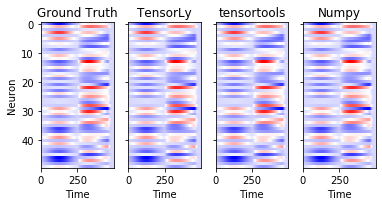

In [12]:
fig, axes = plt.subplots(1, 4, sharey=True)
tensors = [X, M_tl, M_tt, M_np]
titles = ["Ground Truth", "TensorLy", "tensortools", "Numpy"]
trial_num = 50

for title, tensor, ax in zip(titles, tensors, axes):
    ax.imshow(tensor[:, :, trial_num].T, cmap='bwr', aspect=20)
    ax.set_xlabel("Time")
    ax.set_title(title)
axes[0].set_ylabel("Neuron");

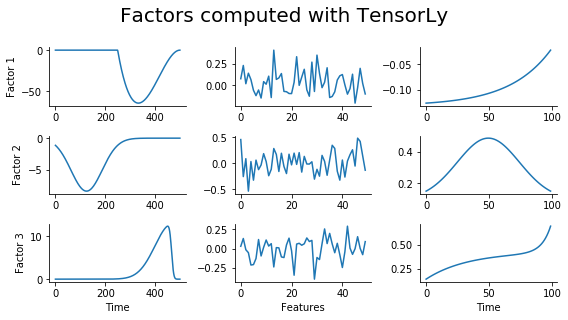

In [13]:
plot_factors(factors_tl, d=3)
plt.suptitle("Factors computed with TensorLy", y=1.1, fontsize=20);

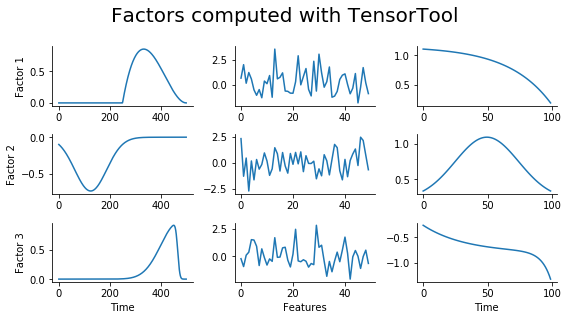

In [14]:
plot_factors(factors_tt, d=3)
plt.suptitle("Factors computed with TensorTool", y=1.1, fontsize=20);

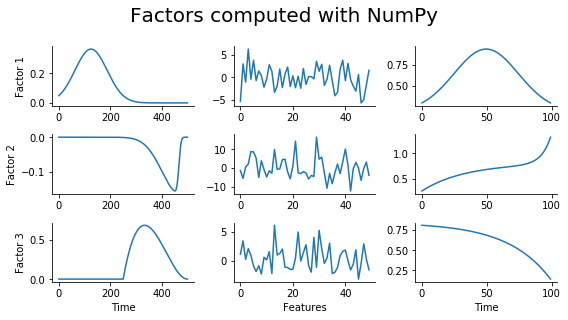

In [15]:
plot_factors(factors_np, d=3)
plt.suptitle("Factors computed with NumPy", y=1.1, fontsize=20);

It turns out that sometimes the factors can be inverted. However, if one of them is inverted, surely another one should also be inverted (-ve time -ve = +ve). 

Hence, depending on the expectations and interpretation that you have from the result, you might need to invert some of the factors. 

Columns correspond to factors, and rows refer to decomposed matrix ($A$, $B$, and $C$).

In [16]:
# a[:, 1] = a[:, 1] * -1
# b[:, 1] = b[:, 1] * -1
# c[:, 2] = c[:, 2] * -1

We are gonna normalize the factors, so that we can compare them with the ground truth (remember that we normalize the true factors (factors_actual) once we imported the data)

In [17]:
a_tl, b_tl, c_tl = factors_tl
a_tt, b_tt, c_tt = factors_tt
a_np, b_np, c_np = factors_np

factors_tl = (normalize(a_tl), normalize(b_tl), normalize(c_tl))
factors_tt = (normalize(a_tt), normalize(b_tt), normalize(c_tt))
factors_np = (normalize(a_np), normalize(b_np), normalize(c_np))

The factors might also be replaced. Hence, in the plotting function below, I have an ordering input where you can choose how to order the factors. So here is what we do:
1. order the factors as they are: `factors_ind=[0, 1, 2]`
2. depending on how they are appearing with respect to the ground truth you can now change the order. For instace: `factors_ind=[1, 0, 2]`

However, in the real application we do not knnow the ground truth. So this part is merely for convinient visualization and assessing the method.

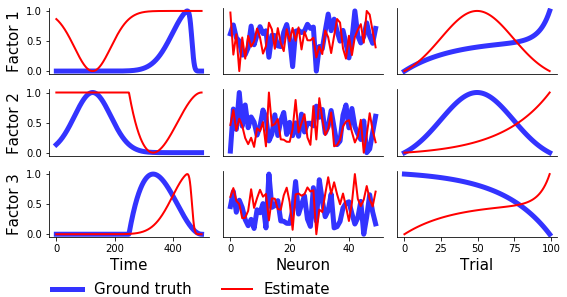

In [18]:
fig, axes = plt.subplots(rank, 3, figsize=(8, int(rank * 1.2 + 1)))
compare_factors(factors_tl, factors_actual, factors_ind=[1, 0, 2], fig=fig);

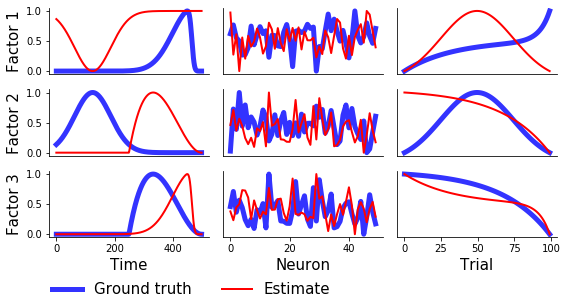

In [19]:
fig, axes = plt.subplots(rank, 3, figsize=(8, int(rank * 1.2 + 1)))
compare_factors(factors_tt, factors_actual, factors_ind=[1, 0, 2], fig=fig);

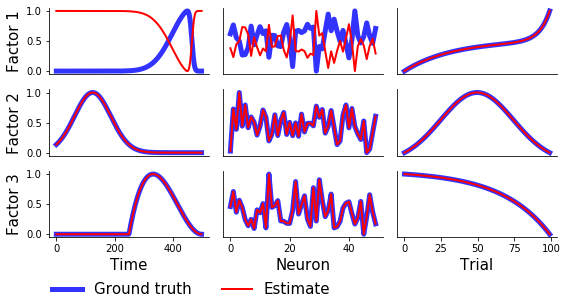

In [20]:
fig, axes = plt.subplots(rank, 3, figsize=(8, int(rank * 1.2 + 1)))
compare_factors(factors_np, factors_actual, factors_ind=[1, 0, 2], fig=fig);

### Comparing the three approaches

#### Reconstruction Error and Time

In [21]:
import timeit

iter_num = 50
times = {'tl': [], 'tt': [], 'np': []}
rec_errors = {'tl': [], 'tt': [], 'np': []}

In [22]:
# TensorLy
for i in range(iter_num):
    start_time = timeit.default_timer()
    factors_tl = parafac(X, rank=rank, tol=0, n_iter_max=200)
    factors_tl = factors_tl.factors
    end_time = timeit.default_timer() - start_time
    times['tl'].append(end_time)
    M_tl = reconstruct(factors_tl)
    rec_error_tl = np.mean((X-M_tl)**2)
    rec_errors['tl'].append(rec_error_tl)
    print("TensorLy | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time))

TensorLy | Iteration: 1 / 50 | time take: 8.825347504 sec
TensorLy | Iteration: 2 / 50 | time take: 8.762432562 sec
TensorLy | Iteration: 3 / 50 | time take: 8.715763732999996 sec
TensorLy | Iteration: 4 / 50 | time take: 8.719531443000001 sec
TensorLy | Iteration: 5 / 50 | time take: 8.782570859000003 sec
TensorLy | Iteration: 6 / 50 | time take: 8.761344034000004 sec
TensorLy | Iteration: 7 / 50 | time take: 8.768364986000009 sec
TensorLy | Iteration: 8 / 50 | time take: 8.767446773000003 sec
TensorLy | Iteration: 9 / 50 | time take: 8.713741474999992 sec
TensorLy | Iteration: 10 / 50 | time take: 8.787926755 sec
TensorLy | Iteration: 11 / 50 | time take: 8.736327989999992 sec
TensorLy | Iteration: 12 / 50 | time take: 8.780060227000007 sec
TensorLy | Iteration: 13 / 50 | time take: 8.831315543000017 sec
TensorLy | Iteration: 14 / 50 | time take: 8.758487839000026 sec
TensorLy | Iteration: 15 / 50 | time take: 8.704516315999996 sec
TensorLy | Iteration: 16 / 50 | time take: 9.1818684

In [23]:
# tensortools
for i in range(iter_num):
    start_time = timeit.default_timer()
    U = tt.cp_als(X, rank=rank, tol=0, max_iter=200, verbose=False)
    factors_tt = U.factors.factors
    end_time = timeit.default_timer() - start_time
    times['tt'].append(end_time)
    M_tt = reconstruct(factors_tt)
    rec_error_tt = np.mean((X-M_tt)**2)
    rec_errors['tt'].append(rec_error_tt)
    print("tensortools | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time))

tensortools | Iteration: 1 / 50 | time take: 9.273768132999976 sec
tensortools | Iteration: 2 / 50 | time take: 9.319568820000029 sec
tensortools | Iteration: 3 / 50 | time take: 9.377860250999959 sec
tensortools | Iteration: 4 / 50 | time take: 9.222798789999956 sec
tensortools | Iteration: 5 / 50 | time take: 9.300502478999988 sec
tensortools | Iteration: 6 / 50 | time take: 9.262774952999962 sec
tensortools | Iteration: 7 / 50 | time take: 9.302390388999925 sec
tensortools | Iteration: 8 / 50 | time take: 9.253030036000041 sec
tensortools | Iteration: 9 / 50 | time take: 9.650316649000047 sec
tensortools | Iteration: 10 / 50 | time take: 9.430578221000019 sec
tensortools | Iteration: 11 / 50 | time take: 9.31303553600003 sec
tensortools | Iteration: 12 / 50 | time take: 9.430058816000042 sec
tensortools | Iteration: 13 / 50 | time take: 9.546491815999957 sec
tensortools | Iteration: 14 / 50 | time take: 9.547742547999974 sec
tensortools | Iteration: 15 / 50 | time take: 9.2882895969

In [24]:
# Numpy
for i in range(iter_num):
    start_time = timeit.default_timer()
    factors_np = decompose_three_way_np(X, rank, max_iter=200, verbose=False)
    end_time = timeit.default_timer() - start_time
    times['np'].append(end_time)
    M_np = reconstruct(factors_np)
    rec_error_np = np.mean((X-M_np)**2)
    rec_errors['np'].append(rec_error_np)
    print("Numpy | Iteration: {} / {} | time take: {} sec".format(i+1, iter_num, end_time))

Numpy | Iteration: 1 / 50 | time take: 1.8864126180000085 sec
Numpy | Iteration: 2 / 50 | time take: 1.8920728219999319 sec
Numpy | Iteration: 3 / 50 | time take: 1.7616670310000018 sec
Numpy | Iteration: 4 / 50 | time take: 1.795167034999963 sec
Numpy | Iteration: 5 / 50 | time take: 1.894963574999906 sec
Numpy | Iteration: 6 / 50 | time take: 1.8975553079999372 sec
Numpy | Iteration: 7 / 50 | time take: 1.8430065509999167 sec
Numpy | Iteration: 8 / 50 | time take: 1.784836420999909 sec
Numpy | Iteration: 9 / 50 | time take: 1.7782329660000187 sec
Numpy | Iteration: 10 / 50 | time take: 1.7748552499999732 sec
Numpy | Iteration: 11 / 50 | time take: 1.7978652580000016 sec
Numpy | Iteration: 12 / 50 | time take: 1.8151459479998948 sec
Numpy | Iteration: 13 / 50 | time take: 1.7913573629999746 sec
Numpy | Iteration: 14 / 50 | time take: 1.814131116999988 sec
Numpy | Iteration: 15 / 50 | time take: 1.7690839719999758 sec
Numpy | Iteration: 16 / 50 | time take: 1.822122823000086 sec
Numpy 

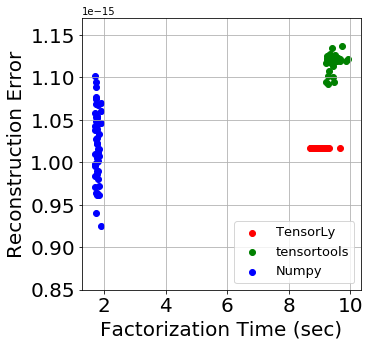

In [25]:
plt.figure(figsize=(5, 5)) #, dpi=200)
factor = 1e15
plt.scatter(np.array(times['tl']), np.array(rec_errors['tl']), c='red', label="TensorLy")
plt.scatter(np.array(times['tt']), np.array(rec_errors['tt']), c='green', label="tensortools")
plt.scatter(np.array(times['np']), np.array(rec_errors['np']), c='b', label="Numpy")
plt.xlabel("Factorization Time (sec)", fontsize=20)
plt.ylabel("Reconstruction Error", fontsize=20)
plt.ylim(0.85 * 1e-15, 1.17 * 1e-15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="lower right", fontsize=13);
plt.grid()

# plt.savefig("metric-1.png", transparent=True, bbox_inches='tight')

**Note** that depending on the result of this test, some values might be outliers. below is a threshold that I applied to remove outliers.

In [26]:
lim = 3 * 1e-15
pkg = 'tt'
times[pkg] = np.array(times[pkg])[np.array(rec_errors[pkg]) < lim].tolist()
rec_errors[pkg] = np.array(rec_errors[pkg])[np.array(rec_errors[pkg]) < lim].tolist()

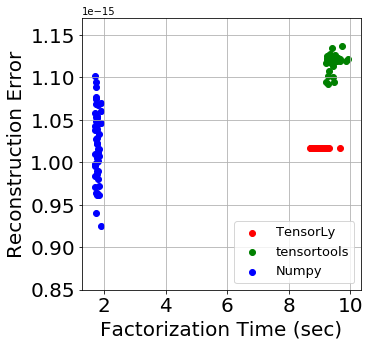

In [27]:
plt.figure(figsize=(5, 5)) #, dpi=200)
factor = 1e15
plt.scatter(np.array(times['tl']), np.array(rec_errors['tl']), c='red', label="TensorLy")
plt.scatter(np.array(times['tt']), np.array(rec_errors['tt']), c='green', label="tensortools")
plt.scatter(np.array(times['np']), np.array(rec_errors['np']), c='b', label="Numpy")
plt.xlabel("Factorization Time (sec)", fontsize=20)
plt.ylabel("Reconstruction Error", fontsize=20)
plt.ylim(0.85 * 1e-15, 1.17 * 1e-15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="lower right", fontsize=13);
plt.grid()

# plt.savefig("metric-1.png", transparent=True, bbox_inches='tight')

---

## Acknowledgement
I would like to thank David Greenberg and Annika Thierfelder for their constructive feedback on the content of this notebook.

## Reference

- Tuncer, Yalcin, Murat M. Tanik, and David B. Allison. "An overview of statistical decomposition techniques applied to complex systems." Computational statistics & data analysis 52.5 (2008): 2292–2310.
- Cichocki, Andrzej, et al. "Tensor decompositions for signal processing applications: From two-way to multiway component analysis." IEEE Signal Processing Magazine 32.2 (2015): 145–163.
- Williams, Alex H., et al. "Unsupervised Discovery of Demixed, Low-Dimensional Neural Dynamics across Multiple Timescales through Tensor Component Analysis." Neuron (2018).
- [Talk](https://www.youtube.com/watch?v=L8uT6hgMt00&t=1302s) by Tamara Kolda
- Tutorial by Alex Williams: [part 1](https://www.youtube.com/watch?v=hmmnRF66hOA), [part 2](https://www.youtube.com/watch?v=O-YTsSuEFiM&t=5s)